### NB-1: Measure linkage decay as topology changes
Goal: take a sequence of newick trees (organized in a **strange** directory) and, for each tree, determine if a specific bipartition is present.

In [1]:
# pip install strange
# conda install seq-gen -c bioconda
# conda install toytree -c eaton-lab
# #strange includes local raxml-ng 

In [2]:
import numpy as np
import pandas as pd
import strange
import toytree
import toyplot

In [3]:
assert int(toytree.__version__.split(".")[-1]) >= 19, "update toytree"
print("toytree", toytree.__version__)
print("strange", strange.__version__)

toytree 0.1.19
strange 0.2-dev


### Define species trees

In [4]:
imb = toytree.tree("(((((((1,2),3),4),5),6),7),8);").mod.make_ultrametric()
imb5 = imb.mod.node_scale_root_height(5)
imb10 = imb.mod.node_scale_root_height(10)

bal = toytree.tree("(((1,2),(3,4)),((5,6),(7,8)));").mod.make_ultrametric()
bal5 = bal.mod.node_scale_root_height(5)
bal10 = bal.mod.node_scale_root_height(10)

### Plot species trees

In [5]:
trees = toytree.mtree([imb5, imb10, bal5, bal10])
canvas, axes = trees.draw_tree_grid(shared_axis=True, orient='down', height=250, width=700)
axes.y.domain.min = -1

2 1 3 4 5 6 7 8 2 1 3 4 5 6 7 8 8 7 6 5 4 3 2 1 8 7 6 5 4 3 2 1 0.0 2.5 5.0 7.5 10.0

### Generate gene trees on species trees

Simulate a chromosome 1Mbp in length with a mutation rate 10X > than recombination rate. This is the result of the function `Coalseq.simulate()` called by `__init__`. 

In [6]:
kwargs = {
    "workdir": "../tests",
    "mutation_rate": 1e-8, 
    "recombination_rate": 1e-9,
    "theta": 0.01, 
    "length": int(1e6), 
    "random_seed": 12345,
}

In [7]:
# setup simulation objects
simi5 = strange.Coalseq(tree=imb5, name="imb5", **kwargs)
simi10 = strange.Coalseq(tree=imb10, name="imb10", **kwargs)
simb5 = strange.Coalseq(tree=bal5, name="bal5", **kwargs)
simb10 = strange.Coalseq(tree=bal10, name="bal10", **kwargs)

In [8]:
# number of breakpoints with length >0
simi5.tree_table.shape

(6235, 6)

### The tree table
This is the result of `Coalseq.get_tree_table()` and `Coalseq.get_sequences()`. For each interval the true genealogy is stored as well as `nsnps` in the simulated sequence data. 

In [9]:
simi5.tree_table.head(10)

start   end  length  nsnps  treeheight  \
0      0   107     107     16     2943223   
1    107   606     499     82     2684972   
2    606   675      69     12     2684972   
3    675   823     148     21     2684972   
4    823   986     163     21     2684972   
5    986  1037      51      7     2684972   
6   1037  1298     261     36     2684972   
7   1298  1310      12      1     2684972   
8   1310  1371      61     12     2684972   
9   1371  1402      31      6     2927746   

                                              mstree  
0  (8:2943223.36414657067508,(7:2301312.881055349...  
1  (8:2684972.08116297377273,(7:2301312.881055349...  
2  (8:2684972.08116297377273,(7:2301312.881055349...  
3  (8:2684972.08116297377273,(7:2301312.881055349...  
4  (8:2684972.08116297377273,(7:2301312.881055349...  
5  (8:2684972.08116297377273,(7:2301312.881055349...  
6  (8:2684972.08116297377273,(7:2301312.881055349...  
7  (8:2684972.08116297377273,(7:2301312.881055349...  
8  ((7:2301312.88105534994975,((6:1866809.3167750...  
9  ((1:938649.90922312706243,(2:823485.7513369959...

### The clade table
This is the result of `Coalseq.get_clade_table()`. It records for each split in the species tree (referenced by the node idx under the split) whether that split is present in each genealogy interval. 


In [10]:
simi5.clade_table.head(10)

8   9   10  11  12  13
0   0   0   1   1   1   1
1   0   0   1   1   1   1
2   0   0   1   0   1   1
3   0   1   0   0   1   1
4   0   1   1   0   1   1
5   0   0   1   0   1   1
6   0   0   0   0   1   1
7   0   1   0   0   1   1
8   0   1   0   0   0   0
9   0   1   0   0   0   0

### Information content of fragments

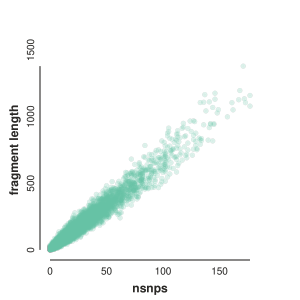

In [11]:
toyplot.config.autoformat = "png"
toyplot.scatterplot(
    simi5.tree_table.nsnps, 
    simi5.tree_table.length,
    width=300, height=300,
    opacity=0.25,
    xlabel='nsnps', ylabel='fragment length',
);

In [12]:
toyplot.config.autoformat = "html"
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(xlabel="fragment length")
axes.bars(
    np.histogram(simi5.tree_table.length),
);

0 500 1000 1500 fragment length 0 1000 2000 3000 4000

### Measure clade support along chromosome

In [13]:
def map_node_colors(ttree):
    ncolors = ttree.get_node_values('idx')
    cidx = 0
    for i in range(len(ncolors)):
        if i in ncolors:
            nidx = ncolors.index(i)
            ncolors[nidx] = toytree.colors[cidx]
            cidx += 1
    return ncolors

In [14]:
def tree_clades_slider_plot(self):
    canvas = toyplot.Canvas(width=500, height=550)
    ax0 = canvas.cartesian(bounds=(75, 425, 50, 250))
    ax1 = canvas.cartesian(bounds=(50, 450, 300, 500), xlabel="Genomic position (Mb)")

    self.tree.draw(
        axes=ax0,
        orient='down', 
        node_sizes=17,
        node_labels=self.tree.get_node_values("idx"),
        node_style={"stroke": "#262626", "fill-opacity": 0.9},
        node_colors=map_node_colors(self.tree),
        tip_labels=False,
    )

    breakpoints = self.tree_table.start
    base = np.zeros(breakpoints.size, dtype=int)
    for col in self.clade_table:
        ax1.fill(
            a=breakpoints,
            b=base, 
            c=base + self.clade_table[col].astype(int), 
            opacity=0.9,
        )
        base += 1

    # styling
    ax0.show = False
    ax1.y.ticks.locator = toyplot.locator.Explicit(
        locations=np.arange(0, 6) + 0.5,
        labels=range(8, 14),
    )
    ax1.x.ticks.locator = toyplot.locator.Explicit(
        locations=np.linspace(0, 1000000, 10),
        labels=range(0, 10),
    )
    ax1.x.ticks.show = True
    ax1.y.ticks.labels.angle = -90
    return canvas, (ax0, ax1)

In [15]:
# for saving figures
import toyplot.svg
import toyplot.pdf

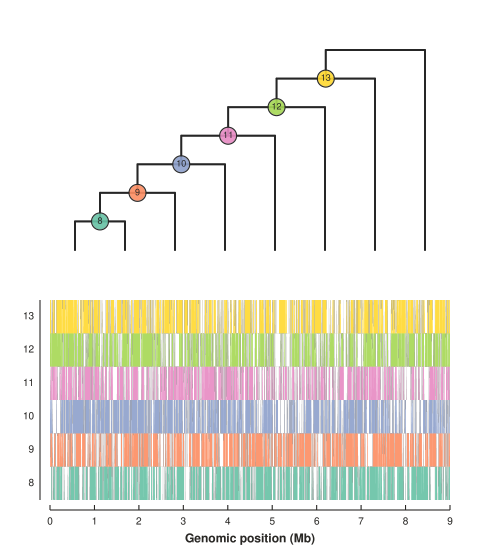

In [16]:
canvas, axes = tree_clades_slider_plot(simi5)
toyplot.html.render(canvas, "../figures/imbalanced_5.html")
toyplot.pdf.render(canvas, "../figures/imbalanced_5.pdf")
canvas

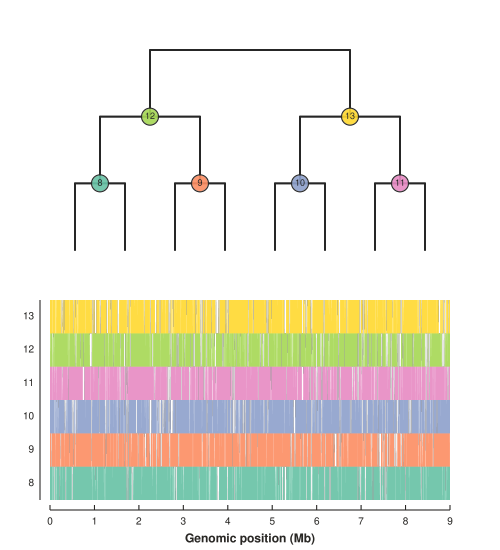

In [17]:
canvas, axes = tree_clades_slider_plot(simb5)
toyplot.html.render(canvas, "../figures/balanced_5.html")
toyplot.pdf.render(canvas, "../figures/balanced_5.pdf")
canvas

### How large are contiguous clade supporting fragments?

Hmmm, there doesn't seem to be a relationship between the depth of a split and the size of fragments (mean or std) that support the split... I thought there would have been...

In [18]:
def get_clade_lengths(self, cidx):
    lengths = []
    flen = 0
    for idx in self.clade_table.index:
        # extend fragment
        if self.clade_table.loc[idx, cidx] == 1:
            flen += 1
        # terminate fragment
        else:
            if flen:
                lengths.append(flen)
                flen = 0
    return np.array(lengths)

In [19]:
dset = simi5
for node in dset.tree.treenode.traverse():
    if not node.is_leaf() and not node.is_root():
        flens = get_clade_lengths(dset, node.idx)
        print("{}\t{:.2f}\t{:.2f}".format(node.idx, flens.mean(), flens.std()))

13	13.28	16.97
12	14.82	19.40
11	11.45	13.15
10	14.45	18.65
9	16.72	19.46
8	17.17	19.87


In [20]:
dset = simi10
for node in dset.tree.treenode.traverse():
    if not node.is_leaf() and not node.is_root():
        flens = get_clade_lengths(dset, node.idx)
        print("{}\t{:.2f}\t{:.2f}".format(node.idx, flens.mean(), flens.std()))

13	29.89	41.73
12	39.71	65.31
11	29.21	40.63
10	26.12	33.25
9	26.88	37.03
8	34.27	43.86
